In [1]:
from gfactor.main.gfactorsolar import SolarSpectrum
from gfactor.querying.LISIRDQuerying import LISIRDRetriever

import numpy as np
import pandas as pd
import math
import random

from datetime import date, timedelta
from datetime import datetime as dt

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, ScalarFormatter
import matplotlib.dates as mdates
import seaborn as sns

import os
from astropy import units as u
from astropy.units import Quantity

### <span style="color:rgb(192, 127, 15);"> Directory </span>

In [2]:
os.chdir("/home/blight25/projects/gfactor")
os.getcwd()

'/home/blight25/projects/gfactor'

### <span style="color:rgb(192, 127, 15);"> Plot Style </span>

In [3]:
sns.set_theme(style="darkgrid", palette="muted")

# <span style="color:rgb(18, 107, 170);"> **<u>Data Loading</u>** </span>

## <span style="color: #12AA83;">SUMER</span>

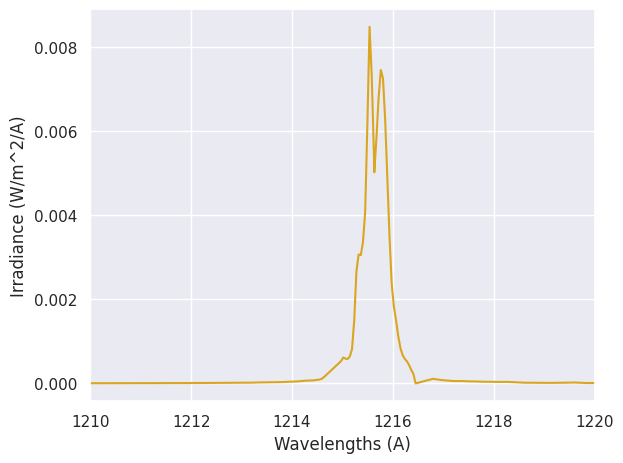

In [4]:
sumer = SolarSpectrum.sumer_spectrum(sumer_file="./spectra/SUMER/SUMER.txt")
fig, ax = plt.subplots()
ax.plot(sumer.spectral_axis, sumer.flux, color="goldenrod")
ax.set_xlabel("Wavelengths (A)")
ax.set_ylabel("Irradiance (W/m^2/A)")
ax.set_xlim(1210, 1220)
fig.tight_layout()
plt.show()

## <span style="color: #12AA83;">NNL</span>

In [5]:
num_samples = 20
retriever = LISIRDRetriever()
GOES_min, GOES_max = retriever.datasets['GOES_18']['min_date'], retriever.datasets['NNL_high_res']['max_date']
date_delta = (GOES_max - GOES_min).days
deltas = []
delta_set = set()
while len(deltas) < num_samples:
    delta = random.randint(0, date_delta)
    if delta in delta_set:
        continue
    else:
        delta_set.add(delta)
    deltas.append(delta)
deltas = np.array(deltas)
deltas.sort()
dates = [GOES_min + timedelta(days=int(delta)) for delta in deltas]
dates = [date.strftime("%Y-%m-%d") for date in dates]
nnl = [SolarSpectrum.daily_spectrum(date=date, dataset="NNL",
                                    res="high",
                                    daily_dir="./spectra") for date in dates]
dates

['2022-09-16',
 '2022-10-03',
 '2022-11-03',
 '2022-11-07',
 '2023-02-01',
 '2023-02-02',
 '2023-02-07',
 '2023-02-09',
 '2023-03-22',
 '2023-04-02',
 '2023-04-11',
 '2023-05-19',
 '2023-06-20',
 '2023-07-08',
 '2023-07-10',
 '2023-07-16',
 '2023-08-14',
 '2023-08-18',
 '2023-10-14',
 '2023-10-25']

# <span style="color:rgb(18, 107, 170);"> **<u>Fit Procedure</u>** </span>

## <span style="color: #12AA83;">**Build Gaussian Kernels**</span>

In [6]:
OI = [1301, 1303.5]
pixel_stds = [None]*num_samples
for i in range(num_samples):
    _, _, _, pixel_stds[i] = nnl[i].feature_fit(fit_func=SolarSpectrum._gaussian_func,
                                                                  feature=OI,     
                                                                  height=1e-5,
                                                                  mean=1302.5,
                                                                  std=.4)

## <span style="color: #12AA83;">**Spectrum Fitting**</span>

In [7]:
outputs = [None]*num_samples
outputs_dc = [None]*num_samples
for i in range(num_samples):
    outputs[i], _, outputs_dc[i], _ = SolarSpectrum.daily_fit(poly_degree=5,
                                                                        sumer=sumer,
                                                                        daily_spec=nnl[i],
                                                                        gaussian_std = pixel_stds[i])

# <span style="color:rgb(18, 107, 170);"> **<u>Fit Results</u>** </span>

### <span style="color:rgb(192, 127, 15);"> Emissions </span>

In [8]:
emissions = {"1175": (1169.1, 1181.7), 
             "1216": (1208.95, 1221.6), 
             "1335": (1328.4, 1341), 
             "1405": (1389.65, 1406.4)}

# <span style="color:rgb(18, 107, 170);"> **<u>GOES Validation</u>** </span>

### <span style="color:rgb(192, 127, 15);"> GOES Data </span>

In [9]:
retriever = LISIRDRetriever()
raw_GOES_data = [retriever.retrieve(dataset="GOES_18", date=date) for date in dates]
raw_GOES_data[0]

,irr_256 (W/m^2),irr_284 (W/m^2),irr_304 (W/m^2),irr_1175 (W/m^2),irr_1216 (W/m^2),irr_1335 (W/m^2),irr_1405 (W/m^2),irr_284_1nm (W/m^2),irr_304_1nm (W/m^2),irr_1216_1nm (W/m^2),...,irr_304_1au,irr_1175_1au,irr_1216_1au,irr_1335_1au,irr_1405_1au,irr_284_1nm_1au,irr_304_1nm_1au,irr_1216_1nm_1au,date (YYYY-MM-DD),Dataset
0,0.000114,0.000088,0.000445,0.000097,0.008024,0.000231,0.000151,0.000095,0.000449,0.007987,...,0.00045,0.000098,0.008111,0.000233,0.000152,0.000096,0.000453,0.008074,2022-09-16,GOES_18


In [10]:
raw_GOES_data = [data.loc[:, ~data.columns.str.contains('flag')] for data in raw_GOES_data]
raw_GOES_data[0].columns

Index(['irr_256 (W/m^2)', 'irr_284 (W/m^2)', 'irr_304 (W/m^2)',
       'irr_1175 (W/m^2)', 'irr_1216 (W/m^2)', 'irr_1335 (W/m^2)',
       'irr_1405 (W/m^2)', 'irr_284_1nm (W/m^2)', 'irr_304_1nm (W/m^2)',
       'irr_1216_1nm (W/m^2)', 'au_factor (dimensionless)', 'irr_256_1au',
       'irr_284_1au', 'irr_304_1au', 'irr_1175_1au', 'irr_1216_1au',
       'irr_1335_1au', 'irr_1405_1au', 'irr_284_1nm_1au', 'irr_304_1nm_1au',
       'irr_1216_1nm_1au', 'date (YYYY-MM-DD)', 'Dataset'],
      dtype='object')

In [11]:
GOES_wavelengths = [wavelength for wavelength in list(emissions.keys())]
GOES_wave_bounds = [bounds for bounds in list(emissions.values())]
GOES_dict = {}
for wavelength in GOES_wavelengths:
    GOES_dict[wavelength] = [data[f"irr_{wavelength} (W/m^2)"].values[0] for data in raw_GOES_data]

GOES = pd.DataFrame(GOES_dict)
GOES.index = dates
GOES

,1175,1216,1335,1405
2022-09-16,0.000097,0.008024,0.000231,0.000151
2022-10-03,0.000106,0.008635,0.000251,0.000163
2022-11-03,0.000103,0.008770,0.000248,0.000158
2022-11-07,0.000105,0.008803,0.000249,0.000161
2023-02-01,NaN,NaN,NaN,NaN
2023-02-02,NaN,NaN,NaN,NaN
2023-02-07,0.000113,0.009390,0.000277,0.000173
2023-02-09,0.000115,0.009483,0.000277,0.000179
2023-03-22,0.000103,0.008612,0.000251,0.000157
2023-04-02,0.000101,0.008644,0.000247,0.000155


## <span style="color: #12AA83;">**Evaluation**</span>

In [12]:
high_res_integrated_dict = {}
low_res_integrated_dict = {}
nnl_integrated_dict = {}
avg_err_dict = {}

high_res_wave_err = low_res_wave_err = nnl_wave_err = None
high_res_tot_err = low_res_tot_err = nnl_tot_err = 0



sumer.emissions = emissions
for key in list(emissions.keys()):
    for i in range(num_samples):
        nnl[i].emissions = emissions
        outputs[i].emissions = emissions
        outputs_dc[i].emissions = emissions

for j, wavelengths in enumerate(GOES_wave_bounds):
    high_res_integrated_dict[GOES_wavelengths[j] + " GOES"] = GOES[GOES_wavelengths[j]]
    high_res_integrated_dict[GOES_wavelengths[j] +  " High Res"] = [outputs[i].emissions[GOES_wavelengths[j]]['Integrated Flux'].value for i in range(num_samples)]
    high_res_percent_err = np.abs(high_res_integrated_dict[GOES_wavelengths[j] + " High Res"] - GOES[GOES_wavelengths[j]]) / GOES[GOES_wavelengths[j]] * 100
    high_res_wave_err = np.sum(high_res_percent_err) / len(high_res_percent_err)
    high_res_tot_err += high_res_wave_err
    high_res_integrated_dict[GOES_wavelengths[j] + " Percent Error"] = high_res_percent_err
    high_res_integrated_dict[f'<SEP_{j}>'] = ''

    low_res_integrated_dict[GOES_wavelengths[j] + " GOES"] = GOES[GOES_wavelengths[j]]
    low_res_integrated_dict[GOES_wavelengths[j] + " Low Res"] = [outputs_dc[i].emissions[GOES_wavelengths[j]]['Integrated Flux'].value for i in range(num_samples)]
    low_res_percent_err = np.abs(low_res_integrated_dict[GOES_wavelengths[j] + " Low Res"] - GOES[GOES_wavelengths[j]]) / GOES[GOES_wavelengths[j]] * 100
    low_res_wave_err = np.sum(low_res_percent_err) / len(low_res_percent_err)
    low_res_tot_err += low_res_wave_err
    low_res_integrated_dict[GOES_wavelengths[j] + " Percent Error"] = low_res_percent_err
    low_res_integrated_dict[f'<SEP>_{j}'] = ''

    nnl_integrated_dict[GOES_wavelengths[j] + " GOES"] = GOES[GOES_wavelengths[j]]
    nnl_integrated_dict[GOES_wavelengths[j] + " NNL"] = [nnl[i].emissions[GOES_wavelengths[j]]['Integrated Flux'].value for i in range(num_samples)]
    nnl_percent_err = np.abs(nnl_integrated_dict[GOES_wavelengths[j] + " NNL"] - GOES[GOES_wavelengths[j]]) / GOES[GOES_wavelengths[j]] * 100
    nnl_wave_err = np.sum(nnl_percent_err) / len(nnl_percent_err)
    nnl_tot_err += nnl_wave_err
    nnl_integrated_dict[GOES_wavelengths[j] + " Percent Error"] = nnl_percent_err
    nnl_integrated_dict[f'<SEP_{j}>'] = ''
    
    avg_err_dict[GOES_wavelengths[j]] = [high_res_wave_err, low_res_wave_err, nnl_wave_err]

avg_err_dict["Total"] = np.array([high_res_tot_err, low_res_tot_err, nnl_tot_err]) / len(GOES_wavelengths)
avg_err = pd.DataFrame(avg_err_dict, index=["High-Res", "Low-Res", "NNL"])
avg_err["Total"] = avg_err["Total"].map(lambda x: f"{x:.2f}%")

high_res_output = pd.DataFrame(high_res_integrated_dict)
high_res_output.index = dates

low_res_output = pd.DataFrame(low_res_integrated_dict)
low_res_output.index = dates

nnl = pd.DataFrame(nnl_integrated_dict)
nnl.index = dates

for wavelength in GOES_wavelengths:
    high_res_output[wavelength + " GOES"] = high_res_output[wavelength + " GOES"].map(lambda x: f"{x:.2e}")
    high_res_output[wavelength + " High Res"] = high_res_output[wavelength + " High Res"].map(lambda x: f"{x:.2e}")
    high_res_output[wavelength + " Percent Error"] = high_res_output[wavelength + " Percent Error"].map(lambda x: f"{x:.2f}%")
    
    low_res_output[wavelength + " GOES"] = low_res_output[wavelength + " GOES"].map(lambda x: f"{x:.2e}")
    low_res_output[wavelength + " Low Res"] = low_res_output[wavelength + " Low Res"].map(lambda x: f"{x:.2e}")
    low_res_output[wavelength + " Percent Error"] = low_res_output[wavelength + " Percent Error"].map(lambda x: f"{x:.2f}%")
    
    nnl[wavelength + " GOES"] = nnl[wavelength + " GOES"].map(lambda x: f"{x:.2e}")
    nnl[wavelength + " NNL"] = nnl[wavelength + " NNL"].map(lambda x: f"{x:.2e}")
    nnl[wavelength + " Percent Error"] = nnl[wavelength + " Percent Error"].map(lambda x: f"{x:.2f}%")
    avg_err[wavelength] = avg_err[wavelength].map(lambda x: f"{x:.2f}%")

In [13]:
high_res_output

,1175 GOES,1175 High Res,1175 Percent Error,<SEP_0>,1216 GOES,1216 High Res,1216 Percent Error,<SEP_1>,1335 GOES,1335 High Res,1335 Percent Error,<SEP_2>,1405 GOES,1405 High Res,1405 Percent Error,<SEP_3>
2022-09-16,9.65e-05,7.90e-05,18.14%,,8.02e-03,8.81e-03,9.79%,,2.31e-04,2.39e-04,3.64%,,1.51e-04,1.42e-04,5.66%,
2022-10-03,1.06e-04,8.26e-05,22.09%,,8.64e-03,9.35e-03,8.32%,,2.51e-04,2.51e-04,0.11%,,1.63e-04,1.48e-04,9.22%,
2022-11-03,1.03e-04,8.22e-05,19.95%,,8.77e-03,9.33e-03,6.42%,,2.48e-04,2.51e-04,1.10%,,1.58e-04,1.47e-04,6.70%,
2022-11-07,1.05e-04,8.25e-05,21.38%,,8.80e-03,9.35e-03,6.22%,,2.49e-04,2.51e-04,0.78%,,1.61e-04,1.48e-04,7.98%,
2023-02-01,nan,8.33e-05,nan%,,nan,9.50e-03,nan%,,nan,2.54e-04,nan%,,nan,1.49e-04,nan%,
2023-02-02,nan,8.37e-05,nan%,,nan,9.59e-03,nan%,,nan,2.56e-04,nan%,,nan,1.50e-04,nan%,
2023-02-07,1.13e-04,8.69e-05,23.36%,,9.39e-03,1.01e-02,7.45%,,2.77e-04,2.67e-04,3.53%,,1.73e-04,1.55e-04,10.32%,
2023-02-09,1.15e-04,8.83e-05,23.20%,,9.48e-03,1.03e-02,8.18%,,2.77e-04,2.71e-04,1.86%,,1.79e-04,1.57e-04,12.14%,
2023-03-22,1.03e-04,8.32e-05,19.43%,,8.61e-03,9.46e-03,9.84%,,2.51e-04,2.54e-04,1.12%,,1.57e-04,1.49e-04,5.27%,
2023-04-02,1.01e-04,8.16e-05,19.32%,,8.64e-03,9.25e-03,6.98%,,2.47e-04,2.49e-04,0.80%,,1.55e-04,1.46e-04,5.48%,


In [14]:
low_res_output

,1175 GOES,1175 Low Res,1175 Percent Error,<SEP>_0,1216 GOES,1216 Low Res,1216 Percent Error,<SEP>_1,1335 GOES,1335 Low Res,1335 Percent Error,<SEP>_2,1405 GOES,1405 Low Res,1405 Percent Error,<SEP>_3
2022-09-16,9.65e-05,8.01e-05,16.98%,,8.02e-03,8.15e-03,1.53%,,2.31e-04,2.34e-04,1.33%,,1.51e-04,1.40e-04,6.96%,
2022-10-03,1.06e-04,8.37e-05,21.00%,,8.64e-03,8.65e-03,0.17%,,2.51e-04,2.46e-04,2.12%,,1.63e-04,1.46e-04,10.46%,
2022-11-03,1.03e-04,8.34e-05,18.83%,,8.77e-03,8.63e-03,1.59%,,2.48e-04,2.45e-04,1.14%,,1.58e-04,1.45e-04,7.98%,
2022-11-07,1.05e-04,8.36e-05,20.28%,,8.80e-03,8.65e-03,1.78%,,2.49e-04,2.46e-04,1.46%,,1.61e-04,1.46e-04,9.24%,
2023-02-01,nan,8.44e-05,nan%,,nan,8.78e-03,nan%,,nan,2.49e-04,nan%,,nan,1.47e-04,nan%,
2023-02-02,nan,8.49e-05,nan%,,nan,8.87e-03,nan%,,nan,2.51e-04,nan%,,nan,1.48e-04,nan%,
2023-02-07,1.13e-04,8.81e-05,22.31%,,9.39e-03,9.33e-03,0.64%,,2.77e-04,2.61e-04,5.67%,,1.73e-04,1.53e-04,11.54%,
2023-02-09,1.15e-04,8.95e-05,22.15%,,9.48e-03,9.49e-03,0.03%,,2.77e-04,2.65e-04,4.04%,,1.79e-04,1.55e-04,13.34%,
2023-03-22,1.03e-04,8.43e-05,18.30%,,8.61e-03,8.75e-03,1.58%,,2.51e-04,2.48e-04,1.12%,,1.57e-04,1.47e-04,6.56%,
2023-04-02,1.01e-04,8.27e-05,18.19%,,8.64e-03,8.55e-03,1.07%,,2.47e-04,2.43e-04,1.44%,,1.55e-04,1.44e-04,6.78%,


In [15]:
nnl

,1175 GOES,1175 NNL,1175 Percent Error,<SEP_0>,1216 GOES,1216 NNL,1216 Percent Error,<SEP_1>,1335 GOES,1335 NNL,1335 Percent Error,<SEP_2>,1405 GOES,1405 NNL,1405 Percent Error,<SEP_3>
2022-09-16,9.65e-05,9.51e-05,1.52%,,8.02e-03,7.81e-03,2.61%,,2.31e-04,2.20e-04,4.65%,,1.51e-04,1.41e-04,6.37%,
2022-10-03,1.06e-04,9.84e-05,7.14%,,8.64e-03,8.29e-03,3.98%,,2.51e-04,2.33e-04,7.19%,,1.63e-04,1.48e-04,9.00%,
2022-11-03,1.03e-04,9.82e-05,4.39%,,8.77e-03,8.27e-03,5.74%,,2.48e-04,2.32e-04,6.31%,,1.58e-04,1.48e-04,6.43%,
2022-11-07,1.05e-04,9.84e-05,6.22%,,8.80e-03,8.29e-03,5.86%,,2.49e-04,2.33e-04,6.57%,,1.61e-04,1.48e-04,7.74%,
2023-02-01,nan,9.92e-05,nan%,,nan,8.40e-03,nan%,,nan,2.36e-04,nan%,,nan,1.50e-04,nan%,
2023-02-02,nan,9.98e-05,nan%,,nan,8.49e-03,nan%,,nan,2.38e-04,nan%,,nan,1.51e-04,nan%,
2023-02-07,1.13e-04,1.03e-04,9.35%,,9.39e-03,8.92e-03,4.96%,,2.77e-04,2.50e-04,9.77%,,1.73e-04,1.58e-04,8.85%,
2023-02-09,1.15e-04,1.04e-04,9.61%,,9.48e-03,9.08e-03,4.24%,,2.77e-04,2.54e-04,8.02%,,1.79e-04,1.60e-04,10.57%,
2023-03-22,1.03e-04,9.90e-05,4.07%,,8.61e-03,8.38e-03,2.67%,,2.51e-04,2.36e-04,6.13%,,1.57e-04,1.50e-04,4.83%,
2023-04-02,1.01e-04,9.77e-05,3.42%,,8.64e-03,8.19e-03,5.26%,,2.47e-04,2.30e-04,6.70%,,1.55e-04,1.47e-04,5.32%,


In [16]:
avg_err

,1175,1216,1335,1405,Total
High-Res,17.61%,9.27%,1.86%,6.24%,8.74%
Low-Res,16.60%,2.36%,1.30%,7.38%,6.91%
NNL,4.06%,2.83%,4.99%,5.50%,4.35%
